# 📈 Stock Market Prediction and Forecasting Using Stacked LSTM  

In this project, I implemented a **Stacked LSTM (Long Short-Term Memory) neural network** to predict and forecast Apple (AAPL) stock prices. The dataset was preprocessed, normalized, and split into training and testing sets. A multi-layer LSTM model was then trained to capture temporal dependencies in stock price data. The model’s performance was evaluated using RMSE, and future stock price predictions for the next 10–30 days were demonstrated with visualizations.  


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## 📊 Dataset Information  

The dataset (`AAPL.csv`) contains **Apple Inc. stock price data** with a total of **1258 entries** and **15 columns**.  
It includes daily trading data such as opening price, closing price, highest and lowest prices, along with adjusted values and trading volume.  

**Dataset Summary:**  
- **Rows (entries):** 1258  
- **Columns:** 15  
- **Memory Usage:** ~147.6 KB  

**Columns Overview:**  
- `Unnamed:0` → Index column  
- `symbol` → Stock ticker symbol (AAPL)  
- `date` → Date of record  
- `close`, `open`, `high`, `low` → Daily trading prices  
- `volume` → Number of shares traded  
- `adjClose`, `adjOpen`, `adjHigh`, `adjLow`, `adjVolume` → Adjusted values for splits/dividends  
- `divCash` → Dividend paid  
- `splitFactor` → Stock split ratio  

This dataset will be used to train the LSTM model for stock price forecasting.  


In [91]:
df=pd.read_csv('AAPL.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1258 non-null   int64  
 1   symbol       1258 non-null   object 
 2   date         1258 non-null   object 
 3   close        1258 non-null   float64
 4   high         1258 non-null   float64
 5   low          1258 non-null   float64
 6   open         1258 non-null   float64
 7   volume       1258 non-null   int64  
 8   adjClose     1258 non-null   float64
 9   adjHigh      1258 non-null   float64
 10  adjLow       1258 non-null   float64
 11  adjOpen      1258 non-null   float64
 12  adjVolume    1258 non-null   int64  
 13  divCash      1258 non-null   float64
 14  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 147.6+ KB


In [92]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


## 🔎 Extracting Closing Price  

From the dataset, we focus only on the **closing price (`close`)** column since it is one of the most important indicators for stock trend analysis.  

- First, the DataFrame index was reset.  
- Then, only the `close` column was selected and stored in a new DataFrame/Series called **`df1`**.  

This gives us a clean time-series of Apple’s daily closing stock prices, which will be used for visualization, normalization, and model training.  


In [93]:
df1=df.reset_index()['close']

## 📉 Closing Price Trend  

The plot above shows the **closing price trend of Apple (AAPL)** over the given time period.  
We can observe:  
- Initial fluctuations with a slight downward trend.  
- Gradual growth starting around the middle of the dataset.  
- Strong upward momentum in the later period, with some sharp corrections.  

This visualization highlights the long-term growth of Apple stock, along with short-term volatility.  
It also shows why sequence learning models like **LSTMs** are suitable — they can capture both trends and temporal dependencies.  


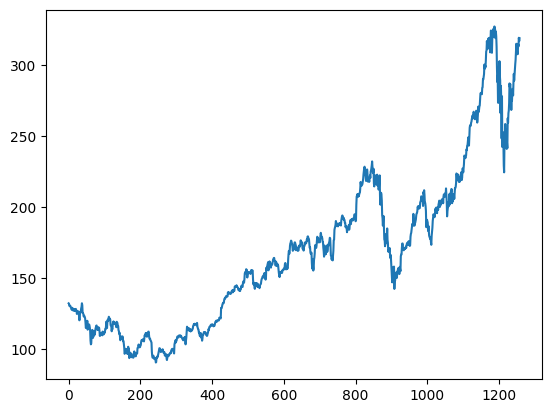

In [94]:
plt.plot(df1)

## ⚙️ Data Normalization  

Before feeding the data into the LSTM model, we apply **Min-Max Scaling** to normalize the closing prices into the range **[0, 1]**.  

- This step ensures that all values are on the same scale, which improves training efficiency and model performance.  
- LSTMs are sensitive to the scale of input data, so normalization helps in faster convergence and reduces the chances of gradient-related issues.  

The transformation was done using `MinMaxScaler` from **scikit-learn**, reshaping the closing price series into a 2D array as required by the scaler.


In [95]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

##  Splitting Dataset into Training and Testing Sets  

To evaluate the model’s performance, the normalized dataset is divided into **training** and **testing** sets:  

- **Training Set:** 70% of the data (~880 records)  
- **Testing Set:** 30% of the data (~378 records)  

The training set is used to fit the LSTM model, while the testing set is used to evaluate its predictive performance on unseen data.  

This split ensures that the model learns from historical trends and can be validated against new, unseen stock price data.  


In [96]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [97]:
training_size,test_size

(880, 378)

## Creating Input Sequences for LSTM  

Since LSTMs work with sequential data, we need to convert the stock price series into **input-output pairs**.  
This is done using a custom function `create_dataset()` which:  

- Takes the dataset and a parameter `time_step` (window size).  
- Creates sequences of length `time_step` as features (**X**).  
- The value immediately following each sequence is taken as the target (**Y**).  

For example, if `time_step = 100`:  
- **Input (X):** Stock prices from `t` to `t+99`  
- **Output (Y):** Stock price at `t+100`  

This transformation helps the LSTM model learn temporal dependencies in stock price movements.  


In [98]:
import numpy as np

def create_dataset(dataset, time_step=1):
    """
    Convert a time series dataset into input-output pairs for supervised learning.
    
    Parameters:
        dataset (ndarray): Input array of shape (n_samples, 1).
        time_step (int): Number of time steps to use for each input sequence.
    
    Returns:
        X (ndarray): Input sequences of shape (n_samples - time_step - 1, time_step).
        y (ndarray): Output values of shape (n_samples - time_step - 1,).
    """
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        seq_x = dataset[i : i + time_step, 0]   # input sequence
        seq_y = dataset[i + time_step, 0]       # target value
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


## 🧩 Creating Training and Testing Sequences  

We set the **time_step = 100**, meaning the model will look back at the previous **100 days of stock prices** to predict the next day’s price.  

- **Training Data:** Converted into `X_train` (input sequences) and `y_train` (corresponding next-day values).  
- **Testing Data:** Converted into `X_test` and `ytest` for evaluation.  

Thus, each input sequence to the LSTM has a shape of **(100, 1)** — representing 100 consecutive days of closing prices as features, with the target being the 101st day’s closing price.  


In [99]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [100]:
print(X_train.shape), print(y_train.shape)

(779, 100)
(779,)


(None, None)

In [101]:
print(X_test.shape), print(ytest.shape)

(277, 100)
(277,)


(None, None)

## 🔄 Reshaping Data for LSTM  

LSTM networks in Keras expect the input in the format:  

**[samples, time steps, features]**  

- **samples:** Number of training examples.  
- **time steps:** Length of each sequence (here, 100 days).  
- **features:** Number of features per time step (here, 1 → closing price).  

So, both `X_train` and `X_test` are reshaped into 3D arrays of shape:  

X_train → (num_samples, 100, 1)
X_test → (num_samples, 100, 1)
This makes the dataset compatible with the LSTM model architecture.  


In [102]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## 🏗️ Building the Stacked LSTM Model  

We construct a **Stacked LSTM (Long Short-Term Memory) network** using Keras’ Sequential API.  

- **LSTM Layers:** Multiple LSTM layers are stacked to capture complex temporal dependencies in stock price data.  
- **Dense Layer:** A fully connected output layer is added at the end to predict the next day’s stock price.  
- **Activation & Optimizer:** The model uses the default LSTM activations (tanh + sigmoid) and is compiled with the **Adam optimizer** and **Mean Squared Error (MSE)** loss.  

This deep stacked architecture enables the model to learn both short-term and long-term stock price patterns effectively.  


In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## 🧮 Stacked LSTM Model Summary  

The model consists of **three LSTM layers** followed by a Dense output layer:  

- **LSTM Layer 1:**  
  - Units: 50  
  - Input shape: (100, 1) → 100 time steps, 1 feature (closing price)  
  - Returns full sequence (`return_sequences=True`) for stacking  

- **LSTM Layer 2:**  
  - Units: 50  
  - Input: sequence from previous layer  
  - Returns sequence to feed into next LSTM layer  

- **LSTM Layer 3:**  
  - Units: 50  
  - Returns only the last output (no `return_sequences`)  

- **Dense Layer:**  
  - Units: 1  
  - Outputs the predicted closing price for the next day  

**Model Parameters:**  
- Total trainable parameters: **50,851**  
- Optimizer: **Adam**  
- Loss function: **Mean Squared Error (MSE)**  

This architecture allows the model to capture both **short-term fluctuations** and **long-term dependencies** in stock price movements.  


In [104]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


C:\Users\ashut\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - loss: 0.0183 - val_loss: 0.0576
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0030 - val_loss: 0.0082
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 8.0511e-04 - val_loss: 0.0060
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 7.6335e-04 - val_loss: 0.0048
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 8.2609e-04 - val_loss: 0.0049
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 7.4746e-04 - val_loss: 0.0064
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 7.8056e-04 - val_loss: 0.0067
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 6.8952e-04 - val_loss: 0.0062
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 6.8752e-04 - val_loss: 0.0075
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 6.7221e-04 - val_loss: 0.0055
Epoch 12/

##  Making Predictions and Evaluating Model  

Once the Stacked LSTM model is trained, we use it to make predictions on:  

- **Training Data (`X_train`)** → to check how well the model has learned historical patterns.  
- **Testing Data (`X_test`)** → to evaluate how well the model generalizes to unseen data.  

The outputs are the predicted stock prices (in normalized form).  
Later, these predictions will be transformed back to the original scale using the `MinMaxScaler` for better interpre


In [127]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [108]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## 📏 Model Performance Evaluation (RMSE)  

To evaluate the accuracy of the predictions, we use the **Root Mean Squared Error (RMSE)** metric:  

\[
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
\]

- \( y_i \) → Actual stock price  
- \( \hat{y}_i \) → Predicted stock price  
- \( n \) → Number of samples  

**Why RMSE?**  
- It penalizes larger errors more heavily than smaller ones.  
- Provides a good measure of how far predictions deviate from actual stock prices.  
- Lower RMSE → Better model performance.  

**Results:**  
- Training RMSE = **149.99**  
- Testing RMSE = **247.73**  

The higher RMSE on the test set compared to the training set suggests some degree of **overfitting**, meaning the model captures historical trends well but struggles more with unseen data.  


In [125]:
import math
from sklearn.metrics import mean_squared_error,r2_score
math.sqrt(mean_squared_error(y_train,train_predict))

149.26978526672565

In [110]:
math.sqrt(mean_squared_error(ytest,test_predict))

246.63034915145803

In [129]:
r2_score(ytest,test_predict)

0.9704767237683064

## 📊 Visualization of Predictions vs Actual Stock Prices  

The plot below compares the **actual stock prices** with the **predicted values** from the LSTM model.  

- **Blue Line** → Actual stock prices (original data).  
- **Orange Line** → Model predictions on the **training set**.  
- **Green Line** → Model predictions on the **testing set**.  

### Key Observations:
1. The model tracks the training data closely, showing strong learning of historical trends.  
2. On the test set, predictions follow the general upward and downward trends but with some deviations, especially at peaks and sharp fluctuations.  
3. This indicates the LSTM captures long-term dependencies well but struggles with sudden changes (common in stock data).  

This visualization helps confirm that the model has learned meaningful patterns while also highlighting areas where predictions diverge.  


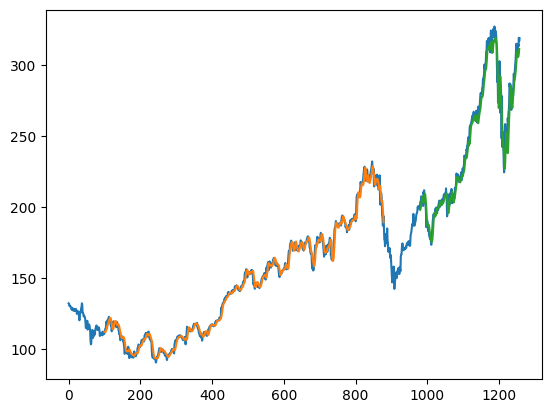

In [111]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Here, we are preparing the input for **future forecasting**:

- `test_data[341:]` → Selects the last portion of the test dataset (from index 341 onwards).  
- `.reshape(1, -1)` → Reshapes the data into a 2D array of shape `(1, n)`, where `n` is the number of selected time steps.  
- `x_input.shape` → Prints the shape of the reshaped array.  

This step ensures that the input format matches the expected input of the LSTM model when generating future predictions.


In [112]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 37)

In [113]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

### Future Forecasting with LSTM

We use the last 100 time steps (`n_steps`) from the test dataset as the seed input and recursively predict the next values.

Steps:
1. **Initialize**:
   - Convert `x_input` into a list (`temp_input`) so predictions can be appended.
   - Create an empty list `lst_output` to store future predictions.

2. **Loop (30 iterations)**:
   - If we already have at least `n_steps` values in `temp_input`, take the last 100 values as input.
   - Reshape to `(1, n_steps, 1)` because the LSTM expects `[samples, time_steps, features]`.
   - Use the model to predict the next value (`yhat`).
   - Append the prediction both to `temp_input` (so it can be used in the next iteration) and to `lst_output` (to keep track of results).

3. **Else Case**:
   - If not enough values are present, pad with zeros until reaching `n_steps`.

4. **Output**:
   - After 30 iterations, `lst_output` contains 30 predicted future values.


In [117]:
import numpy as np

def forecast_next_days(model, temp_input, n_steps=100, days=10):
    """
    Generate future predictions using a trained sequence model.

    Parameters:
        model : Trained model with .predict() method
        temp_input (list) : Initial input sequence (list of values)
        n_steps (int) : Number of timesteps in each input window
        days (int) : Number of future steps to predict

    Returns:
        list : Predicted values for the next `days` steps
    """
    predictions = []

    for day in range(days):
        if len(temp_input) >= n_steps:
            # use last n_steps values
            x_input = np.array(temp_input[-n_steps:]).reshape((1, n_steps, 1))
        else:
            # pad sequence if shorter than n_steps
            pad_len = n_steps - len(temp_input)
            padded_seq = [0] * pad_len + temp_input
            x_input = np.array(padded_seq).reshape((1, n_steps, 1))

        # predict next value
        yhat = model.predict(x_input, verbose=0)

        print(f"Day {day + 1} prediction: {yhat}")

        # update input sequence and store prediction
        temp_input.extend(yhat[0].tolist())
        predictions.extend(yhat.tolist())

    return predictions


lst_output = forecast_next_days(model, temp_input, n_steps=100, days=30)
print(lst_output)


Day 1 prediction: [[0.8413029]]
Day 2 prediction: [[0.82801574]]
Day 3 prediction: [[0.81428146]]
Day 4 prediction: [[0.8000748]]
Day 5 prediction: [[0.78539723]]
Day 6 prediction: [[0.77027816]]
Day 7 prediction: [[0.7547735]]
Day 8 prediction: [[0.7389614]]
Day 9 prediction: [[0.7229369]]
Day 10 prediction: [[0.7068076]]
Day 11 prediction: [[0.6906866]]
Day 12 prediction: [[0.6746887]]
Day 13 prediction: [[0.65892667]]
Day 14 prediction: [[0.6435057]]
Day 15 prediction: [[0.6285227]]
Day 16 prediction: [[0.6140624]]
Day 17 prediction: [[0.6001975]]
Day 18 prediction: [[0.586986]]
Day 19 prediction: [[0.574473]]
Day 20 prediction: [[0.56269014]]
Day 21 prediction: [[0.5516566]]
Day 22 prediction: [[0.54138047]]
Day 23 prediction: [[0.5318605]]
Day 24 prediction: [[0.5230867]]
Day 25 prediction: [[0.5150435]]
Day 26 prediction: [[0.50770915]]
Day 27 prediction: [[0.50105786]]
Day 28 prediction: [[0.4950609]]
Day 29 prediction: [[0.4896866]]
Day 30 prediction: [[0.4849022]]
[[0.84130287

### Forecast Visualization

We plot the last 100 actual data points alongside the next 30 predicted points:

- **Blue Line**: Actual stock prices (last 100 values from dataset).  
- **Orange Line**: LSTM-based forecast for the next 30 days using recursive prediction.  

This allows us to visually compare the model’s short-term forecasting ability and observe how well it follows the existing trend.


In [118]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

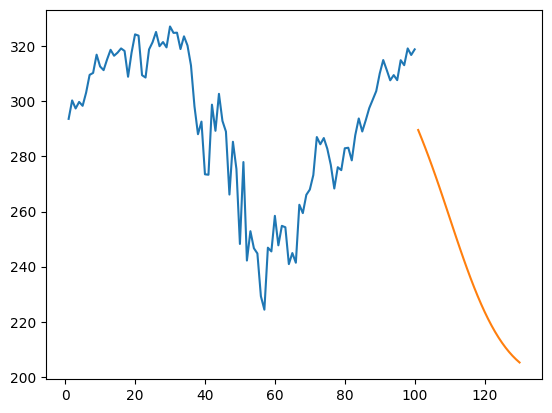

In [119]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

### Extending the Time Series with Future Predictions

- First, we converted the scaled series (`df1`) into a list (`df3`).  
- We then appended (`extend`) the predicted values (`lst_output`) to this list, creating a continuous sequence of historical + forecasted data.  
- Finally, we inverse-transformed (`scaler.inverse_transform`) the data back to the original scale for interpretation and visualization.  

The resulting plot shows:
- The **blue curve**: historical Apple stock prices.  
- The **extension at the end**: the model’s forecast for the next 30 days.  

This gives a realistic continuation of the stock trend based on the trained LSTM model.


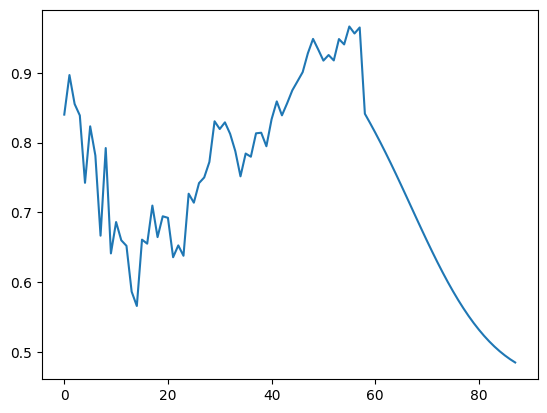

In [120]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [123]:
df3=scaler.inverse_transform(df3).tolist()

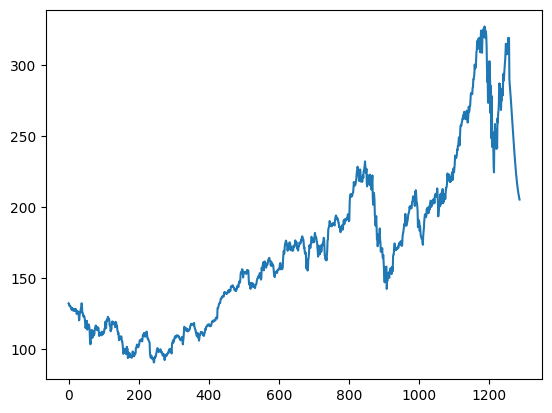

In [122]:
plt.plot(df3)